# 📘 Mini‑Course: Linear Transformations (Theory‑First, Visual, with PCA & Eigenvectors)

This notebook is designed to be **lecture‑ready**: lots of plain‑English explanations, side‑by‑side math, and clear visuals.

### 🎯 Learning Outcomes
By the end, students will be able to:
1. Explain **transformations** and **linear transformations**.
2. Connect transformations to **matrices** and interpret **columns as images of basis vectors**.
3. Visualize standard 2D transformations: **scaling, reflection, shear, rotation**.
4. Understand **determinant** as area‑scaling and why det=0 collapses space.
5. See how **eigenvalues/eigenvectors** are the “special directions” of a transformation.
6. Build **PCA intuition**: a rotation+scaling that “untwists” correlated data.

---
## Why this matters (fast motivation)
- **Data Science/ML:** PCA, whitening, linear models, embeddings.
- **Computer Graphics:** moving/scaling/rotating every vertex with matrices.
- **Engineering/Physics:** coordinate changes, projections, linear systems.


## 1) What is a Transformation?
**Plain English.** A transformation is a rule that takes a vector as input and returns another vector as output.

$$ T: \mathbb{R}^m \to \mathbb{R}^n, \quad w = T(v). $$

**Example (2D → 3D).**
$$ T\begin{bmatrix} v_1 \\ v_2 \end{bmatrix} = \begin{bmatrix} 3v_1 \\ 0 \\ -2v_2 \end{bmatrix}. $$
- Input is a 2D vector $v=(v_1,v_2)$; output is 3D $(3v_1, 0, -2v_2)$.
- Geometric reading: stretch the $x$‑component by 3, kill the old $y$ (send to 0), and create a $z$ component equal to $-2v_2$.


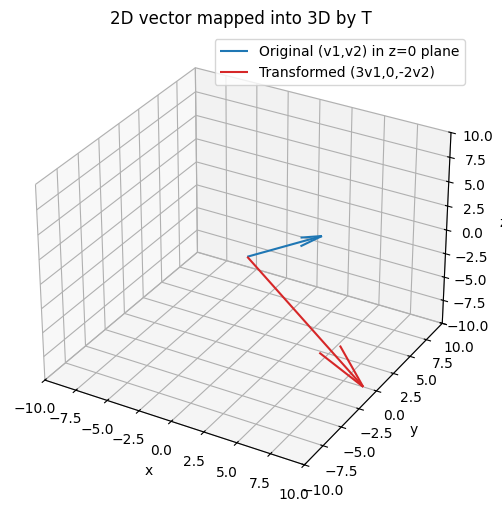

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting

# 2D vector
v = np.array([[3],[5]])  # (v1, v2)
# Transformation T(v) = (3*v1, 0, -2*v2)
w = np.array([[3*v[0,0]],[0],[-2*v[1,0]]])

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0,0,0, v[0,0], v[1,0], 0, color='tab:blue', label='Original (v1,v2) in z=0 plane')
ax.quiver(0,0,0, w[0,0], w[1,0], w[2,0], color='tab:red', label='Transformed (3v1,0,-2v2)')
ax.set_xlim([-10,10]); ax.set_ylim([-10,10]); ax.set_zlim([-10,10])
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('2D vector mapped into 3D by T')
ax.legend(); plt.show()

## 2) What makes a Transformation **Linear**?
**Definition.** $T$ is *linear* if for any vectors $u,v$ and scalar $k$:

1. **Scaling:** $T(kv) = k\,T(v)$
2. **Addition:** $T(u+v) = T(u) + T(v)$

**Intuition.** Linear transformations preserve the origin ($T(0)=0$) and keep straight lines straight. They commute with “mixing” vectors by addition and scaling.


In [2]:
def T_lin(v):
    """T_lin([v1,v2]) = [3*v1, 0, -2*v2]"""
    v1, v2 = v[0,0], v[1,0]
    return np.array([[3*v1],[0],[-2*v2]])

u = np.array([[1],[-2]])
v = np.array([[2],[4]])
k = 3

print('T(kv) =\n', T_lin(k*v))
print('k*T(v)=\n', k*T_lin(v))
print('\nT(u+v) =\n', T_lin(u+v))
print('T(u)+T(v)=\n', T_lin(u)+T_lin(v))

T(kv) =
 [[ 18]
 [  0]
 [-24]]
k*T(v)=
 [[ 18]
 [  0]
 [-24]]

T(u+v) =
 [[ 9]
 [ 0]
 [-4]]
T(u)+T(v)=
 [[ 9]
 [ 0]
 [-4]]


## 3) Matrices **are** Linear Transformations
Every linear transformation can be written as **matrix multiplication**: $L(v)=Av$.

**Example.**
$$ A = \begin{bmatrix}3 & 0 \\ 0 & 0 \\ 0 & -2\end{bmatrix}, \quad Av = \begin{bmatrix}3v_1 \\ 0 \\ -2v_2\end{bmatrix}. $$

Why this is powerful: matrices are easy to compute, combine, and invert (when possible). Composing transformations is just multiplying matrices.


In [3]:
A = np.array([[3,0],[0,0],[0,-2]])
v = np.array([[3],[5]])
print('A =\n', A)
print('Av =\n', A @ v)

A =
 [[ 3  0]
 [ 0  0]
 [ 0 -2]]
Av =
 [[  9]
 [  0]
 [-10]]


## 4) Basis Vectors & Columns of a Matrix
In $\mathbb{R}^2$, the **standard basis** vectors are
$$ e_1 = \begin{bmatrix}1\\0\end{bmatrix}, \quad e_2 = \begin{bmatrix}0\\1\end{bmatrix}. $$

**Key fact.** For any 2×2 matrix $A=[\,Ae_1\;Ae_2\,]$:
- The **first column** of $A$ is $Ae_1$ (image of $e_1$).
- The **second column** of $A$ is $Ae_2$ (image of $e_2$).

If a vector is $v = x\,e_1 + y\,e_2$, then $Av = x\,Ae_1 + y\,Ae_2$. So the entire transformation is determined by where $e_1$ and $e_2$ go.


In [4]:
A2 = np.array([[2,0],[0,1]])  # horizontal scaling by 2 on x
e1 = np.array([[1],[0]])
e2 = np.array([[0],[1]])
print('Ae1 =', (A2 @ e1).ravel())
print('Ae2 =', (A2 @ e2).ravel())

Ae1 = [2 0]
Ae2 = [0 1]


## 5) Visualizing Standard 2D Transformations
We’ll draw **before/after** using colors and a light grid so students see how the whole plane moves.

**Legend**
- Blue arrows: original basis $(e_1,e_2)$.
- Red/orange arrows: transformed $(Ae_1,Ae_2)$.
- Light grid: a few squares to see stretching/shearing/rotating.


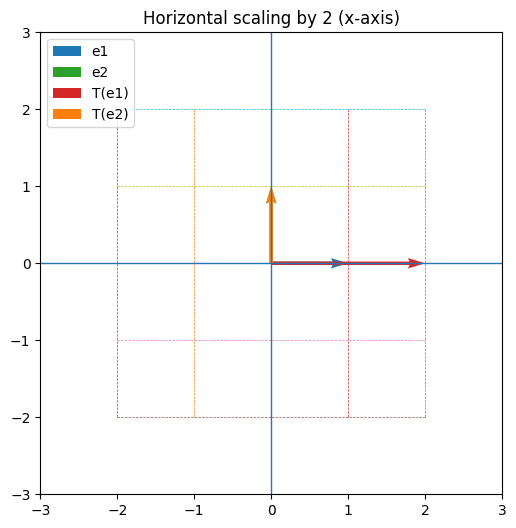

In [5]:
def plot_basis_transform_with_grid(A, title, grid_extent=2):
    e1 = np.array([[1],[0]])
    e2 = np.array([[0],[1]])
    e1_t = A @ e1
    e2_t = A @ e2

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    # light grid squares (original)
    for x in range(-grid_extent, grid_extent+1):
        ax.plot([x, x], [-grid_extent, grid_extent], linestyle='--', linewidth=0.5)
    for y in range(-grid_extent, grid_extent+1):
        ax.plot([-grid_extent, grid_extent], [y, y], linestyle='--', linewidth=0.5)

    # original basis (blue/green)
    ax.quiver(0,0, e1[0,0], e1[1,0], angles='xy', scale_units='xy', scale=1, color='tab:blue', label='e1')
    ax.quiver(0,0, e2[0,0], e2[1,0], angles='xy', scale_units='xy', scale=1, color='tab:green', label='e2')

    # transformed basis (red/orange)
    ax.quiver(0,0, e1_t[0,0], e1_t[1,0], angles='xy', scale_units='xy', scale=1, color='tab:red', label='T(e1)')
    ax.quiver(0,0, e2_t[0,0], e2_t[1,0], angles='xy', scale_units='xy', scale=1, color='tab:orange', label='T(e2)')

    ax.axhline(0, linewidth=1); ax.axvline(0, linewidth=1)
    ax.set_xlim(-3,3); ax.set_ylim(-3,3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

plot_basis_transform_with_grid(np.array([[2,0],[0,1]]), 'Horizontal scaling by 2 (x‑axis)')

### Reflection about the y‑axis
$$ A = \begin{bmatrix}-1 & 0 \\ 0 & 1\end{bmatrix} $$
- Flips $x$; $y$ unchanged. Mirror through vertical axis.


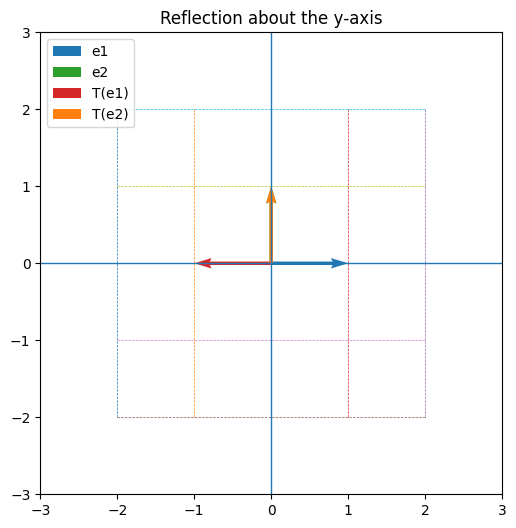

In [6]:
plot_basis_transform_with_grid(np.array([[-1,0],[0,1]]), 'Reflection about the y‑axis')

### Shear in the x‑direction (s=0.5)
$$ A = \begin{bmatrix}1 & s \\ 0 & 1\end{bmatrix},\; s=0.5 $$
- Vertical lines tilt right; areas preserved (det=1).


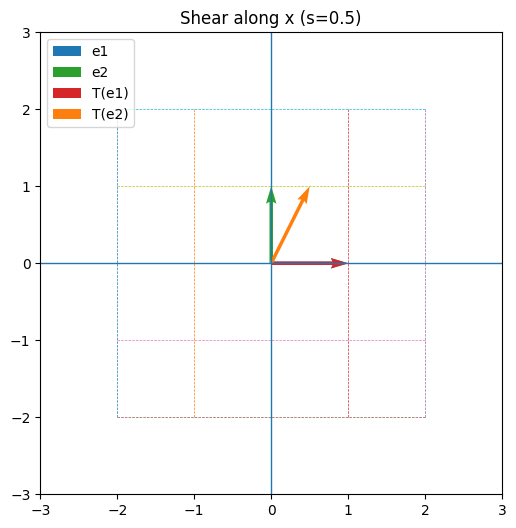

In [7]:
plot_basis_transform_with_grid(np.array([[1,0.5],[0,1]]), 'Shear along x (s=0.5)')

### Rotation by 90° (counter‑clockwise)
$$ A = \begin{bmatrix}0 & -1 \\ 1 & 0\end{bmatrix} $$
- Rotates all vectors by 90° around the origin.
- Lengths and areas preserved (orthogonal, det=1).


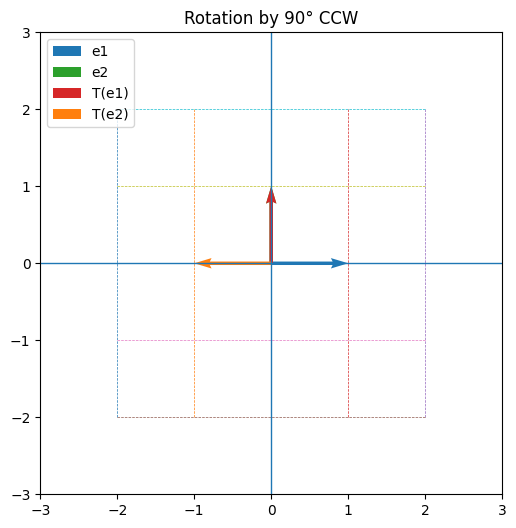

In [8]:
plot_basis_transform_with_grid(np.array([[0,-1],[1,0]]), 'Rotation by 90° CCW')

## 6) Determinant = Area‑Scaling (2D)
If $A=[\,v_1\;v_2\,]$ has columns $v_1,v_2$, then $|\det(A)|$ equals the **area scale** of the unit square. Geometrically, it’s the area of the parallelogram spanned by columns.

- $\det(A)=0$ → area collapses to a line → columns are colinear → **not invertible** → no unique solution to $Ax=b$.
- $|\det(A)|=k$ → every area scales by $k$.


In [9]:
A1 = np.array([[2,0],[0,1]])   # area x2
A2 = np.array([[-1,0],[0,1]])  # area preserved, sign flips (det=-1)
A3 = np.array([[1,0.5],[0,1]]) # shear, det=1 (area preserved)
A4 = np.array([[2,4],[1,2]])   # columns colinear -> det=0

for name,A in [('Scaling',A1),('Reflection',A2),('Shear',A3),('Colinear columns',A4)]:
    print(f'{name:>18}: det(A) = {np.linalg.det(A): .3f}')

           Scaling: det(A) =  2.000
        Reflection: det(A) = -1.000
             Shear: det(A) =  1.000
  Colinear columns: det(A) =  0.000


## 7) Eigenvalues & Eigenvectors: Special Directions
**Idea.** Most vectors change direction under a transformation, but some special vectors don’t: they only **stretch/flip**.

$$ Av = \lambda v $$

- $v$ = eigenvector (direction unchanged)
- $\lambda$ = eigenvalue (scale factor; sign encodes flip)

**Geometric reading.** In 2D, an eigenvector is a line through the origin that maps to itself.


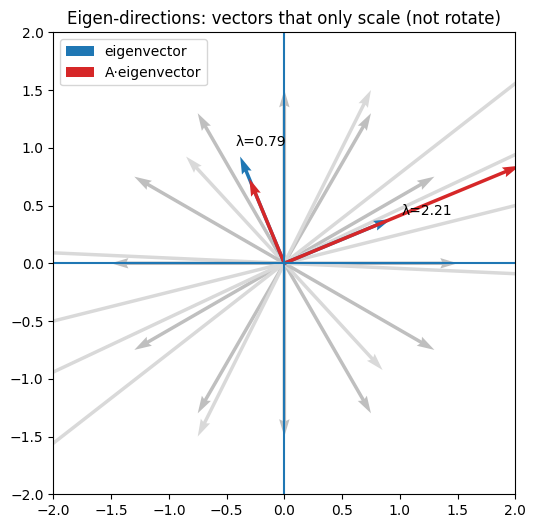

Eigenvalues/eigenvectors of A_ev:
 EigResult(eigenvalues=array([2.20710678, 0.79289322]), eigenvectors=array([[ 0.92387953, -0.38268343],
       [ 0.38268343,  0.92387953]]))


In [10]:
def plot_eigen_directions(A, title, rays=12, length=1.5):
    th = np.linspace(0, 2*np.pi, rays, endpoint=False)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    # draw many directions (gray)
    for t in th:
        v = np.array([[np.cos(t)],[np.sin(t)]])*length
        vt = A @ v
        ax.quiver(0,0, v[0,0], v[1,0], angles='xy', scale_units='xy', scale=1, color='0.75')
        ax.quiver(0,0, vt[0,0], vt[1,0], angles='xy', scale_units='xy', scale=1, color='0.85')
    # compute eigen
    vals, vecs = np.linalg.eig(A)
    for i in range(vecs.shape[1]):
        v = vecs[:,i].reshape(2,1)
        vt = A @ v
        ax.quiver(0,0, v[0,0], v[1,0], angles='xy', scale_units='xy', scale=1, color='tab:blue', label='eigenvector' if i==0 else None)
        ax.quiver(0,0, vt[0,0], vt[1,0], angles='xy', scale_units='xy', scale=1, color='tab:red', label='A·eigenvector' if i==0 else None)
        ax.text(v[0,0]*1.1, v[1,0]*1.1, f'λ={vals[i]:.2f}', fontsize=10)
    ax.axhline(0); ax.axvline(0)
    ax.set_xlim(-2,2); ax.set_ylim(-2,2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

# Example with distinct real eigenvalues (symmetric scaling+shear)
A_ev = np.array([[2, 0.5],[0.5, 1]])
plot_eigen_directions(A_ev, 'Eigen‑directions: vectors that only scale (not rotate)')

print('Eigenvalues/eigenvectors of A_ev:\n', np.linalg.eig(A_ev))

### Notes
- Some transformations (like pure rotation by 90°) have **no real eigenvectors**: every direction turns.
- Symmetric matrices (e.g., covariance matrices) always have **real eigenvalues** and orthogonal eigenvectors. This is why PCA works so nicely.


## 8) PCA Intuition: “Untwisting” Data (Rotate + Scale)
**Goal.** Given correlated 2D data (slanted ellipse), PCA finds a new basis (principal components) that aligns with the spread. Then we can **rotate** data into that basis and optionally **scale** to normalize variance.

Pipeline:
1. Center data (subtract mean).
2. Compute covariance matrix $\Sigma$.
3. Eigendecompose: $\Sigma = Q\Lambda Q^T$ (columns of $Q$ are principal directions).
4. **Rotate** data: $X_{\text{rot}} = X Q$.
5. Optionally **scale** (whiten): $X_{\text{white}} = X Q \Lambda^{-1/2}$.

- $Q$: rotation to principal axes.
- $\Lambda$: variances along those axes (eigenvalues).


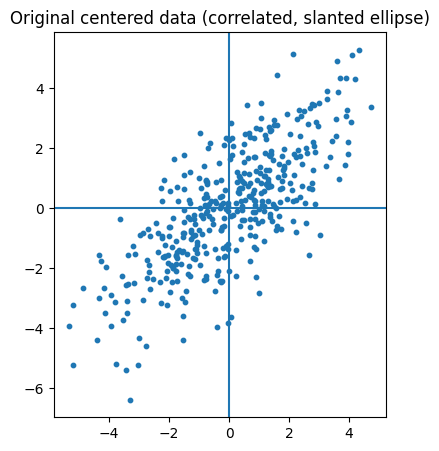

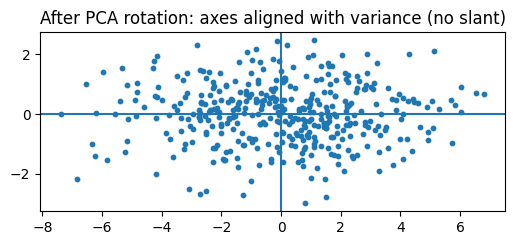

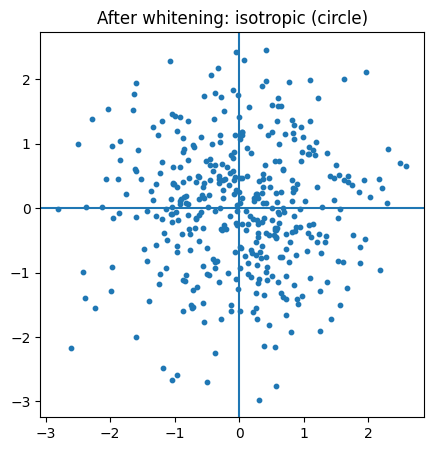

Eigenvalues (variances along PCs): [6.85696298 1.0106769 ]
Principal directions (columns of Q):
 [[ 0.70681665 -0.7073968 ]
 [ 0.7073968   0.70681665]]


In [11]:
np.random.seed(0)
n = 400
# generate correlated 2D data
mean = np.array([0.0, 0.0])
cov  = np.array([[4.0, 3.0],[3.0, 4.0]])  # highly correlated
X = np.random.multivariate_normal(mean, cov, size=n)

# center
Xc = X - X.mean(axis=0)
Sigma = (Xc.T @ Xc) / (n-1)

# eigen decomposition of covariance
vals, vecs = np.linalg.eigh(Sigma)  # eigh for symmetric
# sort descending by eigenvalue
idx = np.argsort(vals)[::-1]
vals = vals[idx]
vecs = vecs[:, idx]

# rotate into PC basis
X_rot = Xc @ vecs
# whiten (optional): scale each PC by 1/sqrt(lambda)
eps = 1e-9
Lambda_inv_sqrt = np.diag(1.0/np.sqrt(vals+eps))
X_white = Xc @ vecs @ Lambda_inv_sqrt

# plot original (centered)
plt.figure(figsize=(6,5))
plt.scatter(Xc[:,0], Xc[:,1], s=10)
plt.axhline(0); plt.axvline(0)
plt.title('Original centered data (correlated, slanted ellipse)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# plot rotated (principal axes aligned)
plt.figure(figsize=(6,5))
plt.scatter(X_rot[:,0], X_rot[:,1], s=10)
plt.axhline(0); plt.axvline(0)
plt.title('After PCA rotation: axes aligned with variance (no slant)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# plot whitened (variances normalized)
plt.figure(figsize=(6,5))
plt.scatter(X_white[:,0], X_white[:,1], s=10)
plt.axhline(0); plt.axvline(0)
plt.title('After whitening: isotropic (circle)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

print('Eigenvalues (variances along PCs):', vals)
print('Principal directions (columns of Q):\n', vecs)

### Why PCA is a linear transformation
- The map $X \mapsto XQ$ is a **rotation** (change of basis): still linear.
- The map $X \mapsto XQ\Lambda^{-1/2}$ is rotation + **scaling**: still linear.
- Geometrically, PCA finds the **best rotated axes** to describe variance.

> In the next class, you can dig into optimization views (max variance), data compression, and reconstruction using top PCs.


## 9) Composition: **Order Matters** ($BA \neq AB$)
If you first apply $A$ then $B$, the overall effect is $BA$. In general, $BA$ and $AB$ are different matrices → **different results**.


In [12]:
A_rot = np.array([[0,-1],[1,0]])      # 90° CCW rotation
A_shx = np.array([[1,0.5],[0,1]])     # shear x
print('A_rot @ A_shx =\n', A_rot @ A_shx)
print('\nA_shx @ A_rot =\n', A_shx @ A_rot)

A_rot @ A_shx =
 [[ 0.  -1. ]
 [ 1.   0.5]]

A_shx @ A_rot =
 [[ 0.5 -1. ]
 [ 1.   0. ]]


## 10) Key Takeaways
- Linear transformations preserve scaling and addition; they keep lines straight and the origin fixed.
- Matrices **are** linear transformations; columns show where basis vectors go.
- Determinant measures area/volume scaling and invertibility.
- Eigenvectors are special directions that don’t rotate; eigenvalues are their stretch factors.
- PCA = rotate to principal directions (and optionally scale): it **untwists** correlated data.
